# Data Collection and Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# Load the list of tickers from a CSV file
tickers = pd.read_csv('/content/drive/MyDrive/Medium/acoes-listadas-b3.csv')['Ticker'].tolist() # https://www.dadosdemercado.com.br/acoes

# Append '.SA' to each ticker to match Yahoo Finance format for Brazilian stocks
tickers = [ticker + '.SA' for ticker in tickers]

# Download adjusted closing price data
data = yf.download(tickers, start='2023-09-01', end='2024-09-01')['Adj Close']

# Remove columns with incomplete data
data = data.dropna(axis=1)

[*********************100%***********************]  405 of 405 completed
ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['DASA11.SA', 'BIOM11.SA', 'AZEV11.SA', 'AMAR11.SA', 'PINE11.SA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BRAV3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-09-01 -> 2024-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1693537200, endDate = 1725159600")')


# Identifying Potential Pairs (Correlation)

In [2]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Compute the correlation matrix
corr_matrix = returns.corr()

# Set a correlation threshold
threshold = 0.8

# Find highly correlated pairs
correlated_pairs = []
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and abs(corr_matrix.loc[i, j]) > threshold:
            correlated_pairs.append((i, j))

# Remove duplicate pairs
correlated_pairs = list(set([tuple(sorted(pair)) for pair in correlated_pairs]))

# Testing for Cointegration (using Engle-Granger)

In [3]:
# Function to test for cointegration
def test_cointegration(pair):
    stock1 = data[pair[0]]
    stock2 = data[pair[1]]
    score, p_value, _ = coint(stock1, stock2)
    return {'Stock1': pair[0], 'Stock2': pair[1], 'P-Value': p_value}

# Test for cointegration among correlated pairs
results = []
for pair in correlated_pairs:
    try:
        result = test_cointegration(pair)
        results.append(result)
    except Exception as e:
        print(f"Error testing cointegration for pair {pair}: {e}")

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Filter pairs with significant cointegration
cointegrated_pairs = df_results[df_results['P-Value'] < 0.01]

print("Cointegrated Pairs:")
print(cointegrated_pairs)

Cointegrated Pairs:
       Stock1    Stock2       P-Value
4   TAEE11.SA  TAEE3.SA  2.288997e-06
11  SAPR11.SA  SAPR3.SA  7.076157e-03
13  SANB11.SA  SANB3.SA  4.751526e-03
14  SAPR11.SA  SAPR4.SA  8.426332e-04
15  TAEE11.SA  TAEE4.SA  3.290741e-09
22  KLBN11.SA  KLBN3.SA  9.055637e-03
24  KLBN11.SA  KLBN4.SA  1.246334e-13
25   AZEV3.SA  AZEV4.SA  2.576622e-04
26   POMO3.SA  POMO4.SA  1.830864e-03
28   ITSA3.SA  ITSA4.SA  1.253472e-08


In [4]:
import re

# Function to identify the stock group
def remove_numbers(stock):
    return re.sub(r'\d+', '', stock)

# Create 'Group' column
cointegrated_pairs = cointegrated_pairs.copy()  # Make an explicit copy to avoid warning
cointegrated_pairs['Group'] = cointegrated_pairs['Stock1'].apply(remove_numbers)

# Select the pair with the lowest p-value per group
min_p_value_pairs = cointegrated_pairs.loc[cointegrated_pairs.groupby('Group')['P-Value'].idxmin()]

# Drop 'Group' column
min_p_value_pairs = min_p_value_pairs.drop(columns=['Group'])

print("Cointegrated pairs with the lowest P-Value per group:")
print(min_p_value_pairs)

Cointegrated pairs with the lowest P-Value per group:
       Stock1    Stock2       P-Value
25   AZEV3.SA  AZEV4.SA  2.576622e-04
28   ITSA3.SA  ITSA4.SA  1.253472e-08
24  KLBN11.SA  KLBN4.SA  1.246334e-13
26   POMO3.SA  POMO4.SA  1.830864e-03
13  SANB11.SA  SANB3.SA  4.751526e-03
14  SAPR11.SA  SAPR4.SA  8.426332e-04
15  TAEE11.SA  TAEE4.SA  3.290741e-09


# Modeling and Calculating the Spread


Calculating spread for pair: AZEV3.SA and AZEV4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


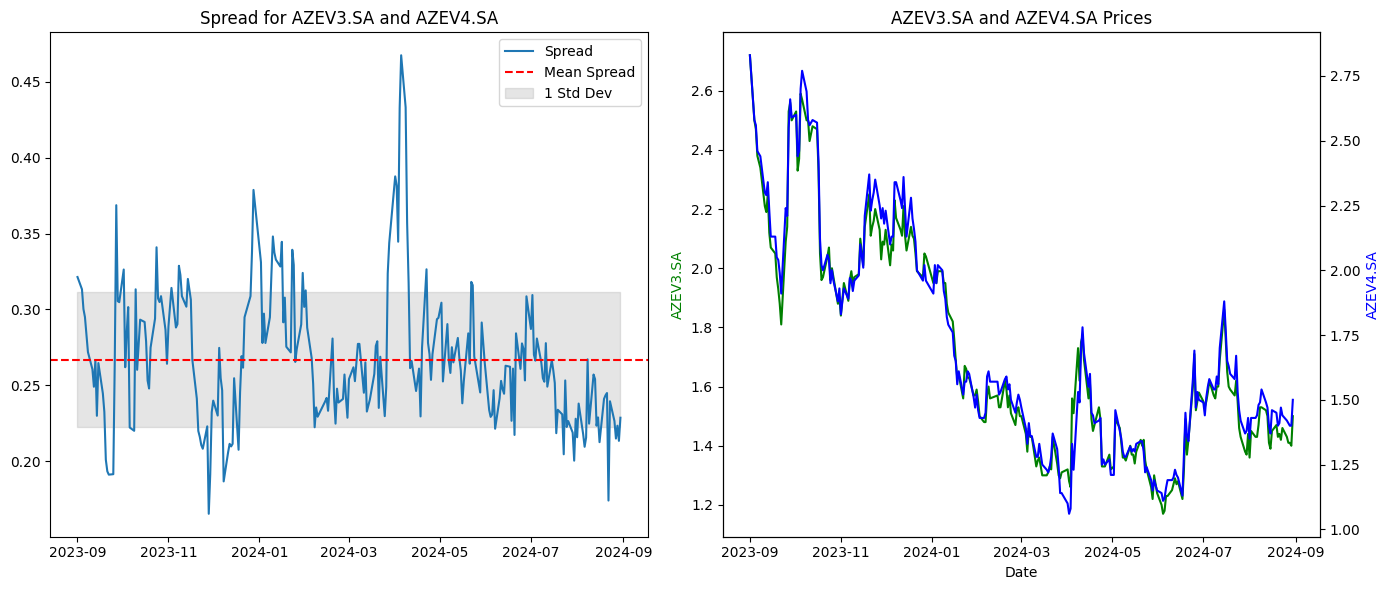

Calculating spread for pair: ITSA3.SA and ITSA4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


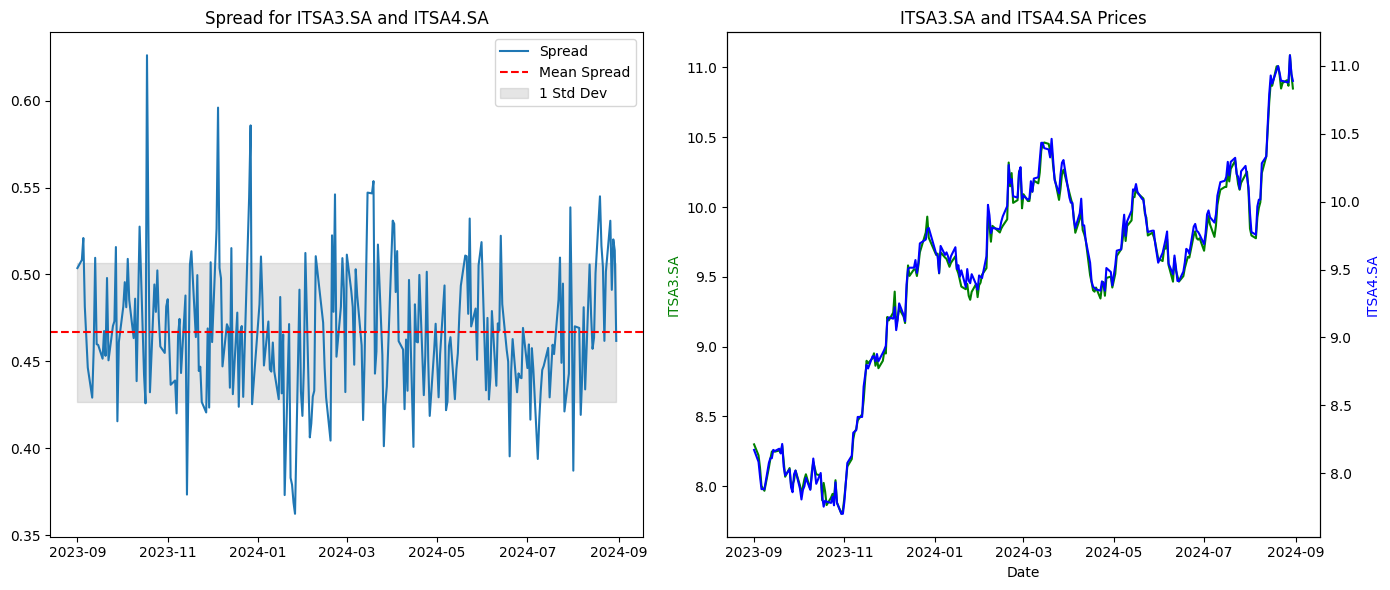

Calculating spread for pair: KLBN11.SA and KLBN4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


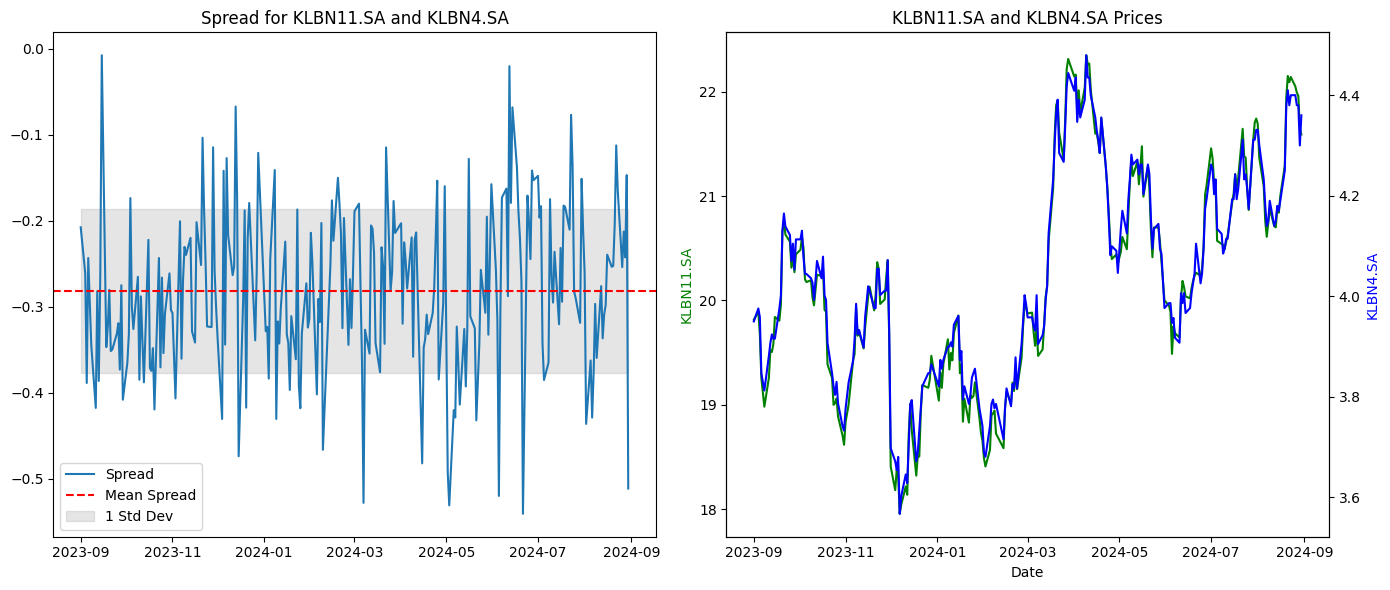

Calculating spread for pair: POMO3.SA and POMO4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


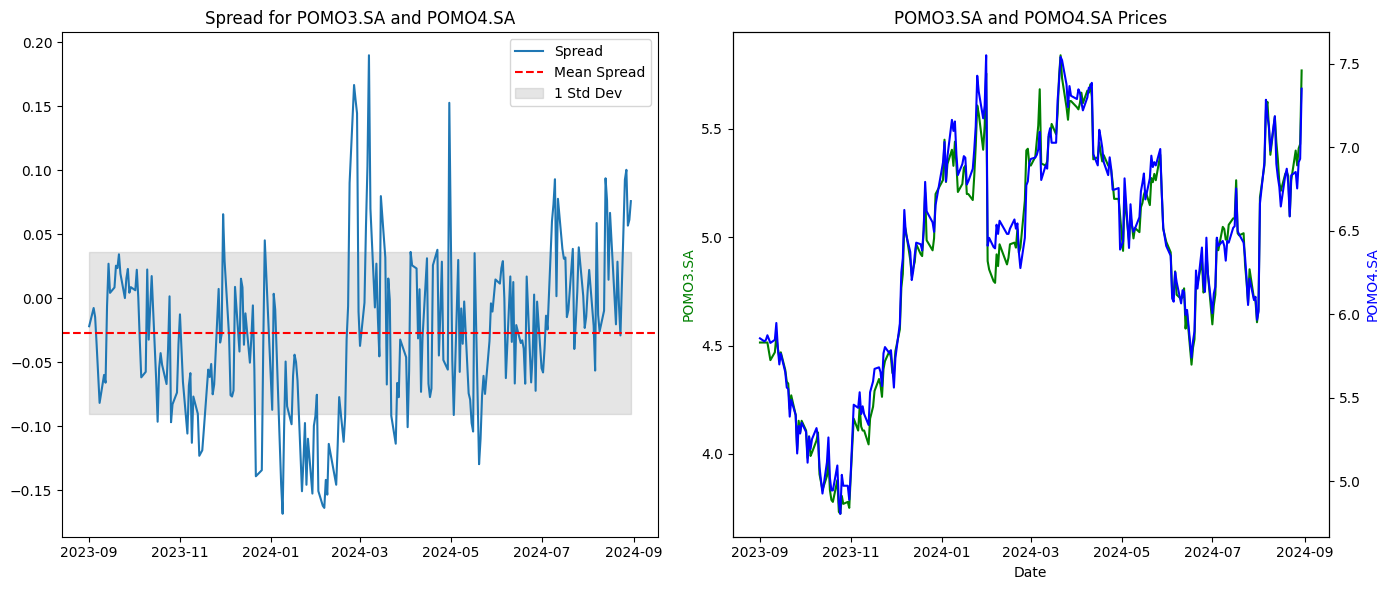

Calculating spread for pair: SANB11.SA and SANB3.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


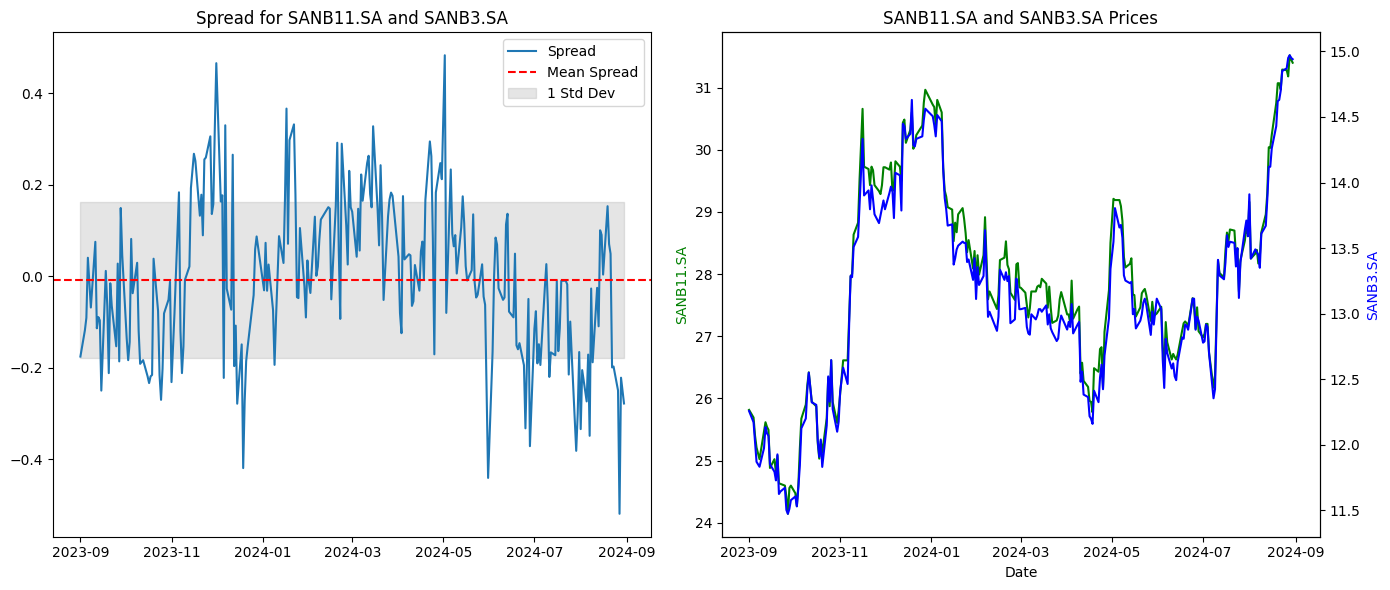

Calculating spread for pair: SAPR11.SA and SAPR4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


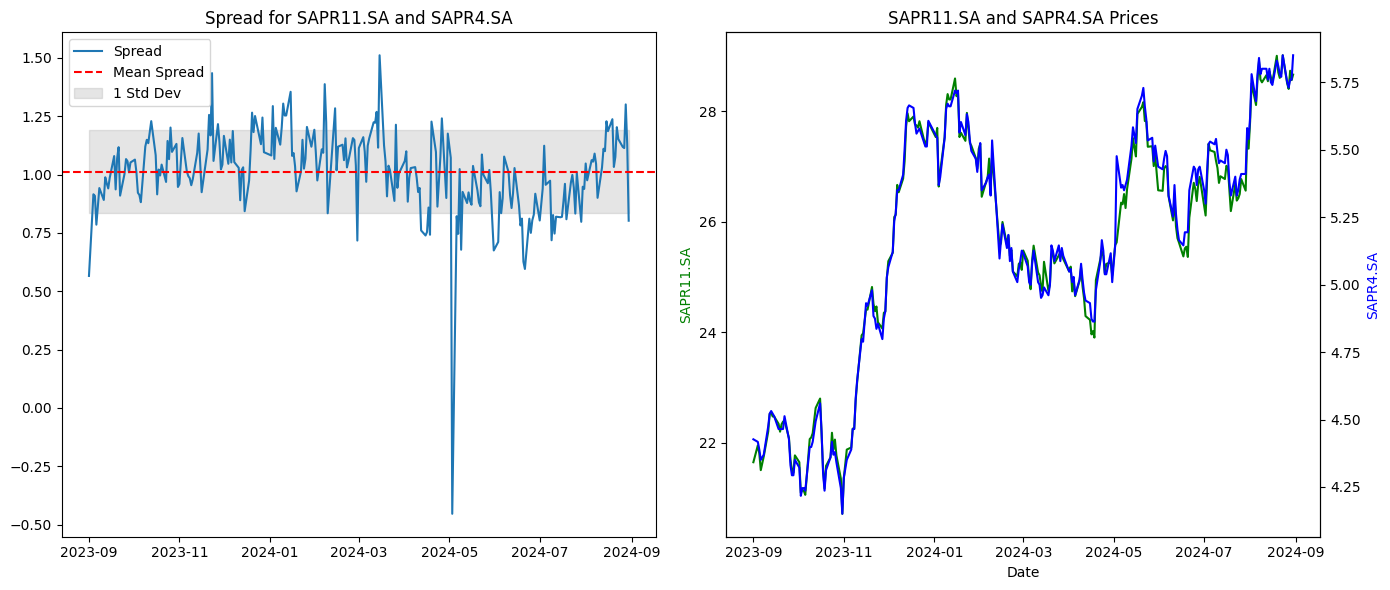

Calculating spread for pair: TAEE11.SA and TAEE4.SA


<ipython-input-5-4a0f954e5045>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = stock1 - model.params[1] * stock2


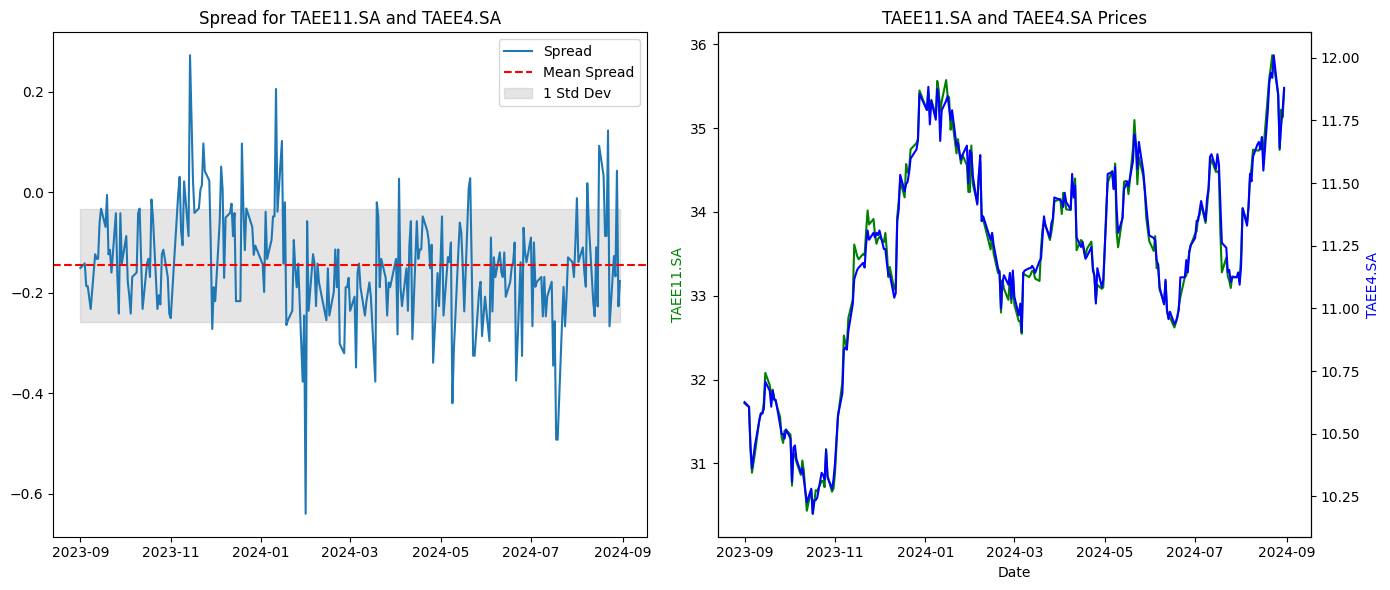

In [5]:
models_and_means = []

def calculate_spread(pair):
    stock1 = data[pair[0]]
    stock2 = data[pair[1]]

    # Train the linear regression model
    X = sm.add_constant(stock2)
    model = sm.OLS(stock1, X).fit()

    # Calculate the spread
    spread = stock1 - model.params[1] * stock2

    # Calculate mean and standard deviation of the spread
    mean_spread = spread.mean()
    std_spread = spread.std()

    # Save the model and statistics
    models_and_means.append({'model': model, 'mean_spread': mean_spread, 'std_spread': std_spread})

    return spread, mean_spread, std_spread, stock1, stock2

# Loop through pairs and calculate the spread
for _, row in min_p_value_pairs.iterrows():
    stock1 = row['Stock1']
    stock2 = row['Stock2']
    print(f"Calculating spread for pair: {stock1} and {stock2}")

    spread, mean_spread, std_spread, stock1_data, stock2_data = calculate_spread((stock1, stock2))

    # Plotting the spread and stock prices
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Spread plot
    ax[0].plot(spread, label='Spread')
    ax[0].axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
    ax[0].fill_between(spread.index, mean_spread - std_spread, mean_spread + std_spread, color='gray', alpha=0.2, label='1 Std Dev')
    ax[0].set_title(f'Spread for {stock1} and {stock2}')
    ax[0].legend()

    # Stock prices plot
    ax1 = ax[1]
    ax2 = ax1.twinx()
    ax1.plot(stock1_data.index, stock1_data, 'g-', label=stock1)
    ax2.plot(stock2_data.index, stock2_data, 'b-', label=stock2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(stock1, color='g')
    ax2.set_ylabel(stock2, color='b')
    ax1.set_title(f'{stock1} and {stock2} Prices')
    fig.tight_layout()
    plt.show()

# Strategy Implementation and Testing


## Fetching Test Data and Calculating Test Spread

In [6]:
# Fetch test data
def fetch_all_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    return data[['Open', 'Adj Close']]

start_strategy = '2024-09-01'
end_strategy = '2024-10-01'

tickers = min_p_value_pairs['Stock1'].tolist() + min_p_value_pairs['Stock2'].tolist()
tickers = list(set(tickers))

df_test = fetch_all_stock_data(tickers, start_strategy, end_strategy)

[*********************100%***********************]  14 of 14 completed


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


Testing spread for pair: AZEV3.SA and AZEV4.SA


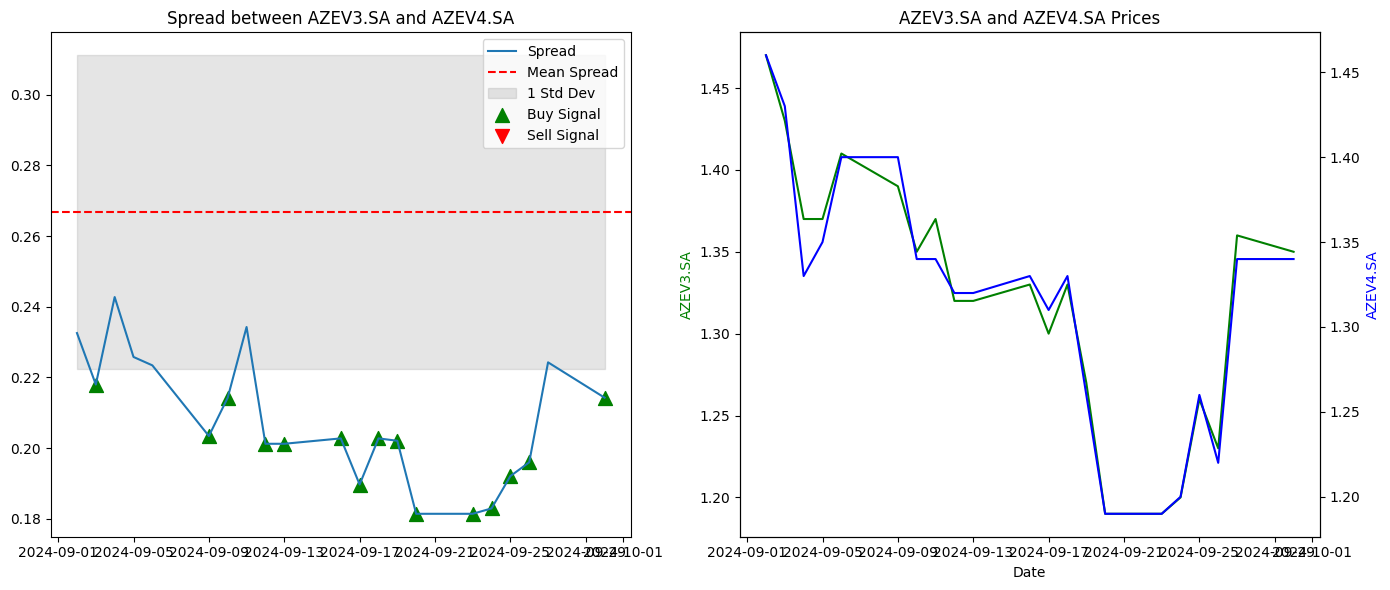

Testing spread for pair: ITSA3.SA and ITSA4.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


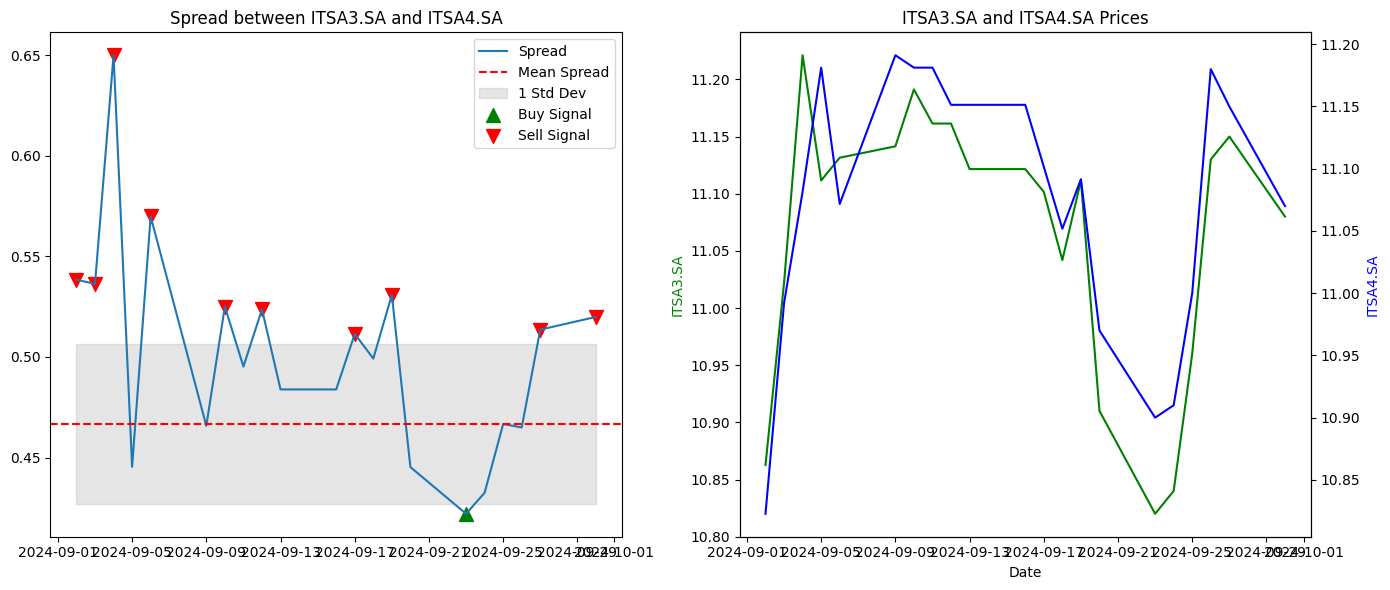

Testing spread for pair: KLBN11.SA and KLBN4.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


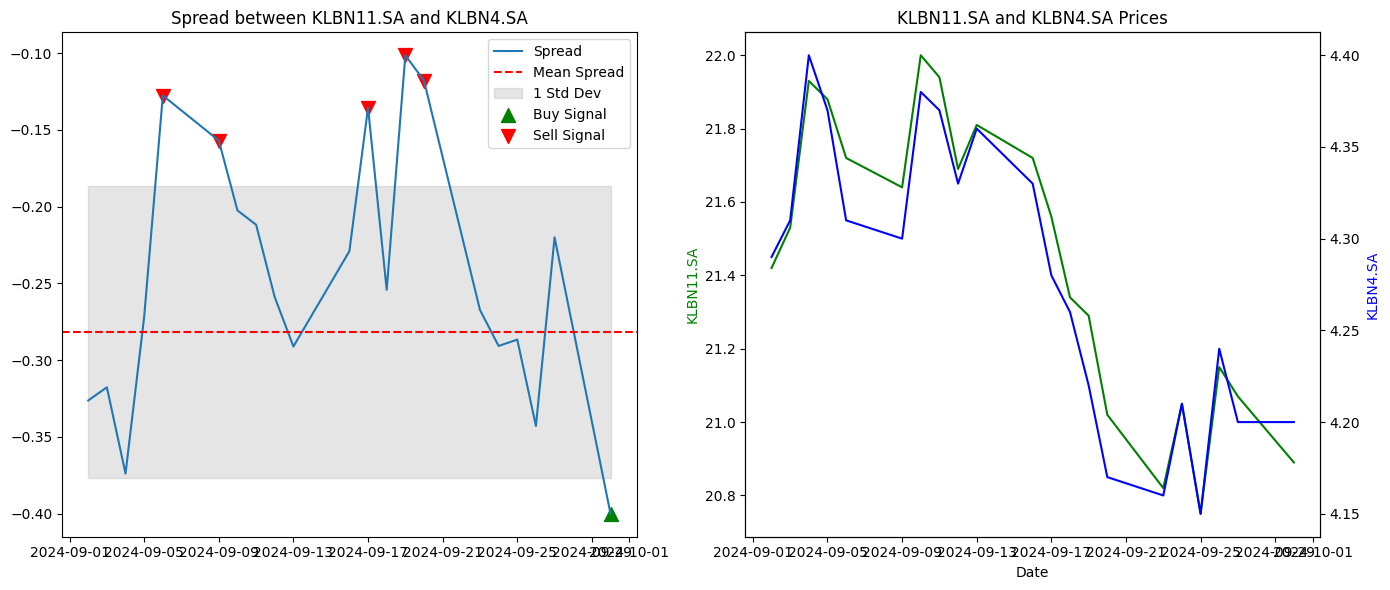

Testing spread for pair: POMO3.SA and POMO4.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


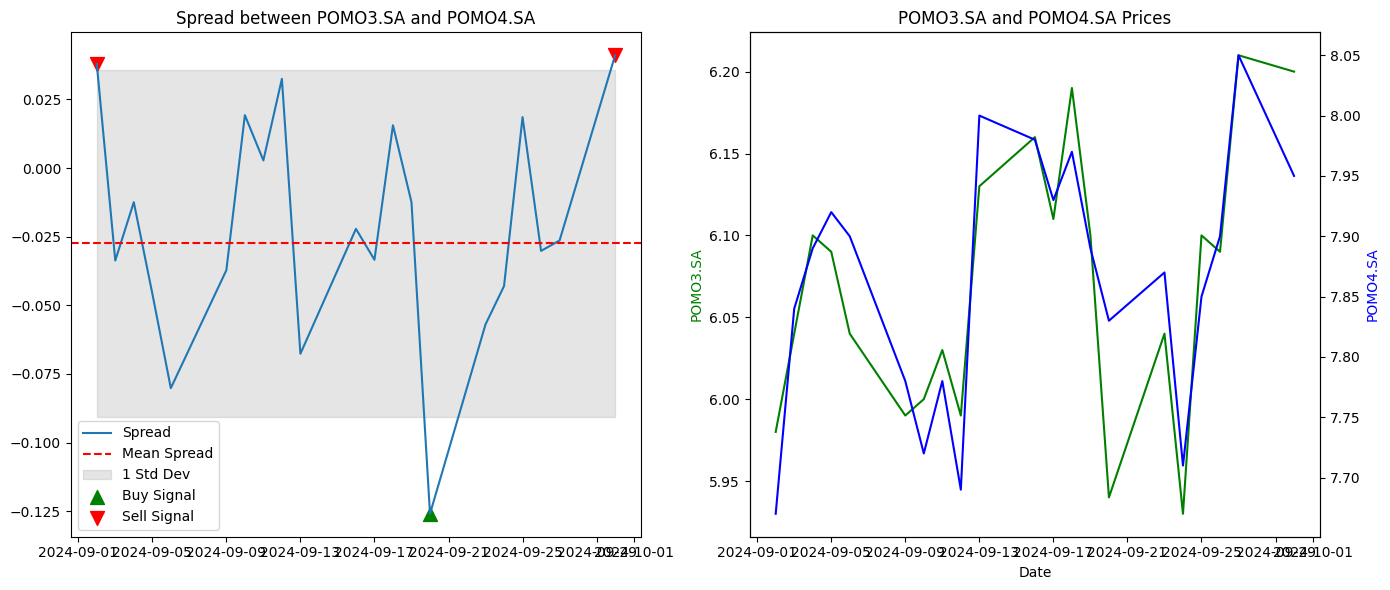

Testing spread for pair: SANB11.SA and SANB3.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


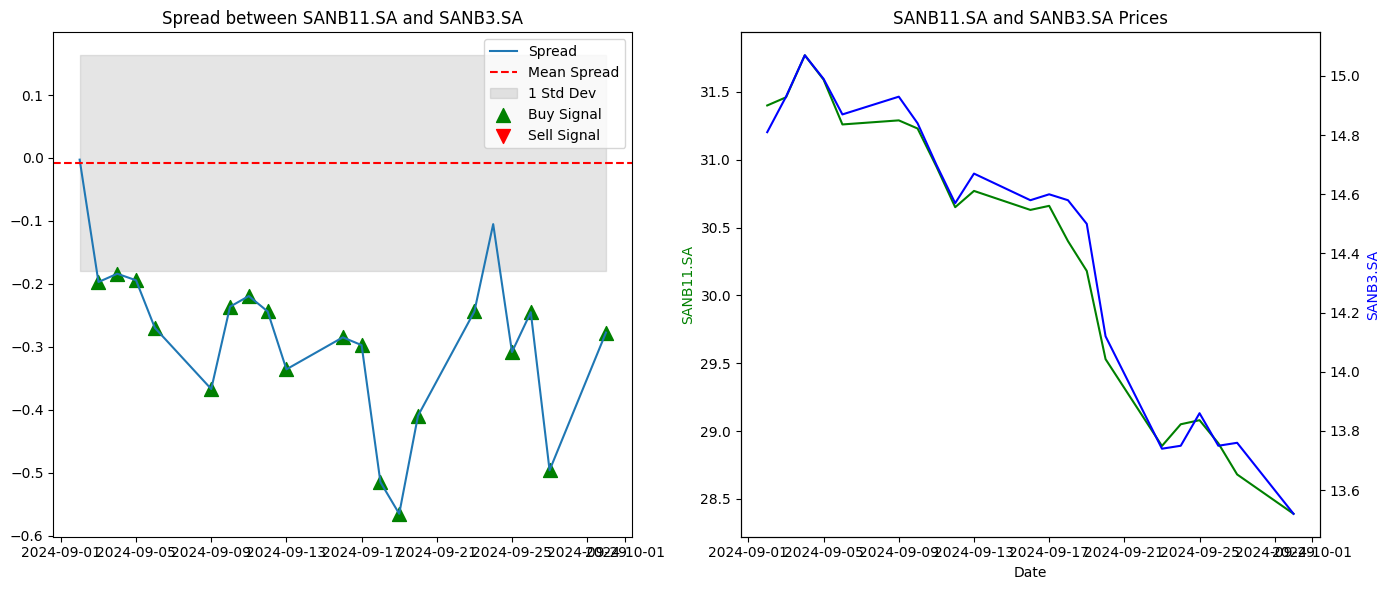

Testing spread for pair: SAPR11.SA and SAPR4.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


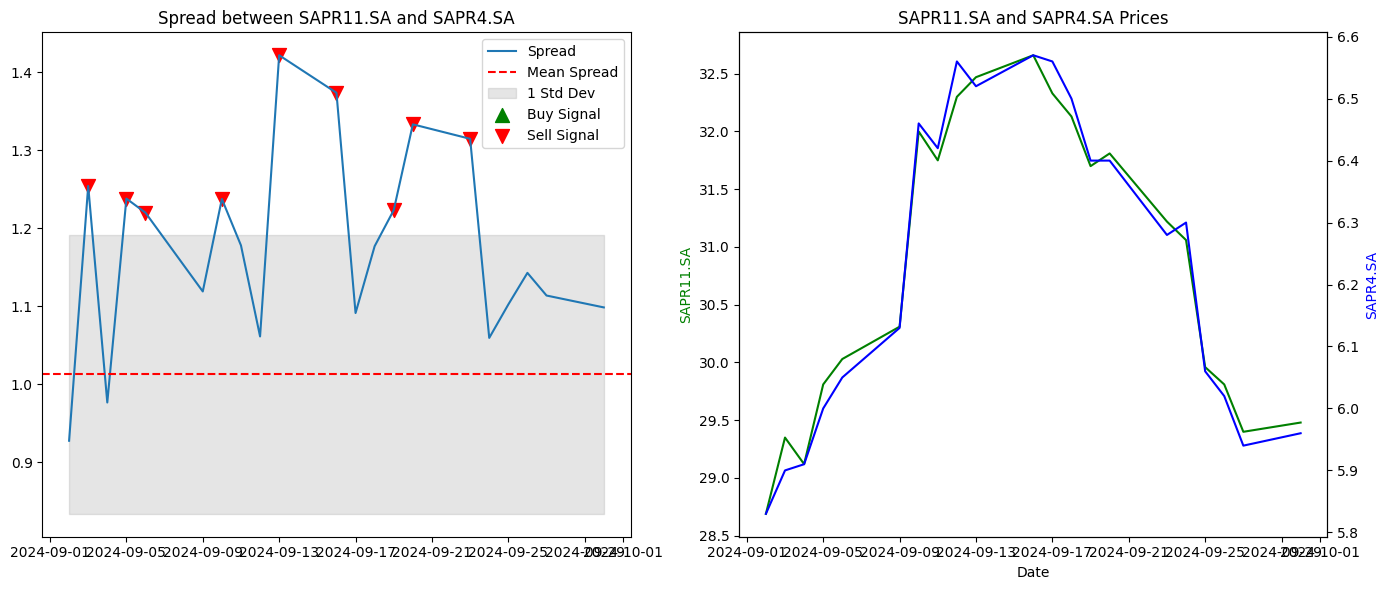

Testing spread for pair: TAEE11.SA and TAEE4.SA


<ipython-input-7-1192f43603a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']


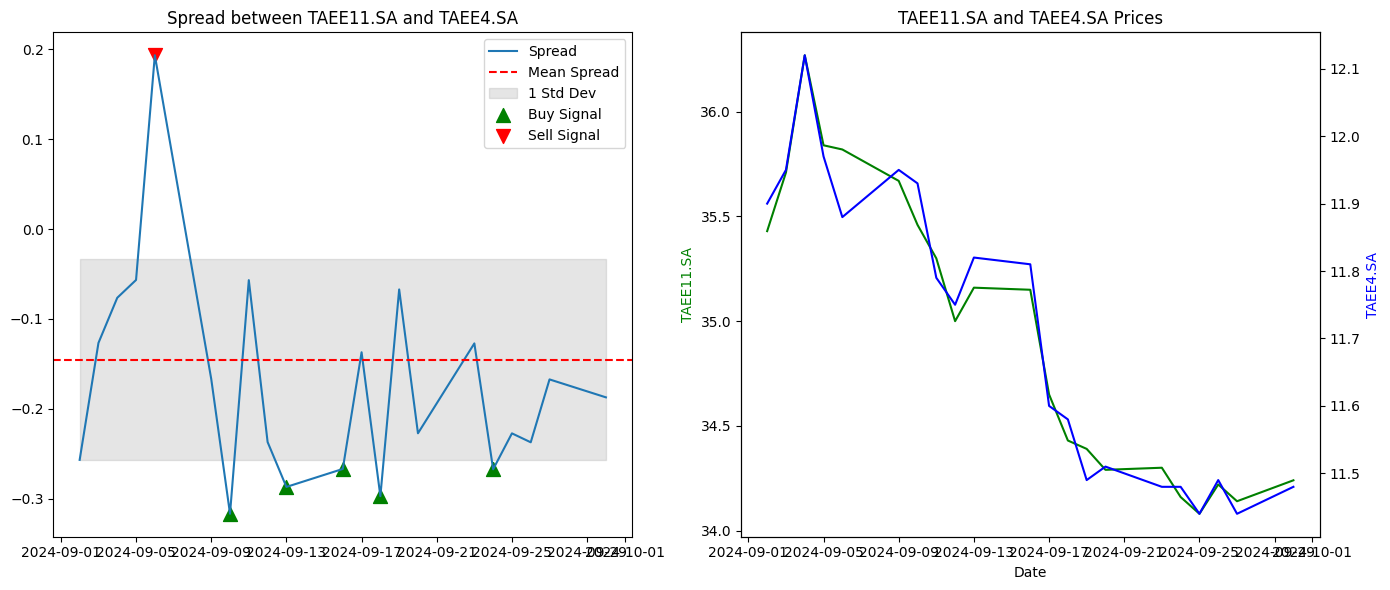

In [7]:
# Function to calculate test spread and signals
def calculate_test_spread(pair, df_test, model, mean_spread, std_spread):
    stock1 = pair[0]
    stock2 = pair[1]

    # Prepare the data
    df_pair = pd.DataFrame({
        f'{stock1}_Open': df_test['Open'][stock1],
        f'{stock1}_Close': df_test['Adj Close'][stock1],
        f'{stock2}_Open': df_test['Open'][stock2],
        f'{stock2}_Close': df_test['Adj Close'][stock2]
    }).dropna()

    # Calculate the spread
    df_pair['Spread'] = df_pair[f'{stock1}_Close'] - model.params[1] * df_pair[f'{stock2}_Close']

    # Define trading signals
    df_pair['Buy_Signal'] = df_pair['Spread'] < (mean_spread - std_spread)
    df_pair['Sell_Signal'] = df_pair['Spread'] > (mean_spread + std_spread)

    # Determine positions
    df_pair['Position'] = 0
    df_pair['Position'] = np.where(df_pair['Buy_Signal'], 1, np.where(df_pair['Sell_Signal'], -1, 0))

    # Plot the spread and signals
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Spread plot
    ax[0].plot(df_pair.index, df_pair['Spread'], label='Spread')
    ax[0].axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
    ax[0].fill_between(df_pair.index, mean_spread - std_spread, mean_spread + std_spread, color='gray', alpha=0.2, label='1 Std Dev')

    # Mark signals
    buy_signals = df_pair[df_pair['Buy_Signal']]
    sell_signals = df_pair[df_pair['Sell_Signal']]
    ax[0].scatter(buy_signals.index, buy_signals['Spread'], marker='^', color='green', s=100, label='Buy Signal')
    ax[0].scatter(sell_signals.index, sell_signals['Spread'], marker='v', color='red', s=100, label='Sell Signal')
    ax[0].set_title(f'Spread between {stock1} and {stock2}')
    ax[0].legend()

    # Stock prices plot
    ax1 = ax[1]
    ax2 = ax1.twinx()
    ax1.plot(df_pair.index, df_pair[f'{stock1}_Close'], 'g-', label=stock1)
    ax2.plot(df_pair.index, df_pair[f'{stock2}_Close'], 'b-', label=stock2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(stock1, color='g')
    ax2.set_ylabel(stock2, color='b')
    ax1.set_title(f'{stock1} and {stock2} Prices')
    fig.tight_layout()
    plt.show()

    return df_pair

# Apply the test spread calculation
def test_spread_for_all_pairs(min_p_value_pairs, models_and_means, df_test):
    for i, (index, row) in enumerate(min_p_value_pairs.iterrows()):
        stock1 = row['Stock1']
        stock2 = row['Stock2']
        print(f"Testing spread for pair: {stock1} and {stock2}")

        model = models_and_means[i]['model']
        mean_spread = models_and_means[i]['mean_spread']
        std_spread = models_and_means[i]['std_spread']

        calculate_test_spread((stock1, stock2), df_test, model, mean_spread, std_spread)

# Execute the test
test_spread_for_all_pairs(min_p_value_pairs, models_and_means, df_test)

## Applying Costs and Taxes

In [8]:
# Function to apply short selling cost and taxes, with adjustments for multiple pairs
def apply_costs_and_taxes(df, short_fee=0.10):
    daily_short_fee = (1 + short_fee) ** (1 / 252) - 1  # Adjust annual fee to daily

    # Calculate returns for both stocks
    df['Stock1_Return'] = (df['Stock1_Close'] - df['Stock1_Open']) / df['Stock1_Open']
    df['Stock2_Return'] = (df['Stock2_Close'] - df['Stock2_Open']) / df['Stock2_Open']

    # Calculate strategy return: Buy Stock1 and sell Stock2 (or vice versa)
    df['Strategy_Return'] = df['Position'] * (df['Stock1_Return'] - df['Stock2_Return'])

    # Apply short selling cost for both long and short positions
    df.loc[df['Position'] != 0, 'Strategy_Return'] -= daily_short_fee

    # Apply 20% tax on profits for both long and short positions
    df['Strategy_Return_After_Tax'] = np.where(df['Strategy_Return'] > 0,
                                               df['Strategy_Return'] * 0.80,  # 20% tax on profit
                                               df['Strategy_Return'])         # No tax on loss

    return df

## Executing the Strategy Across All Pairs


<ipython-input-9-2ea79febb354>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_test['Spread'] = df_test['Stock1_Close'] - model.params[1] * df_test['Stock2_Close']
<ipython-input-9-2ea79febb354>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_test['Spread'] = df_test['Stock1_Close'] - model.params[1] * df_test['Stock2_Close']
<ipython-input-9-2ea79febb354>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_test['Spread']

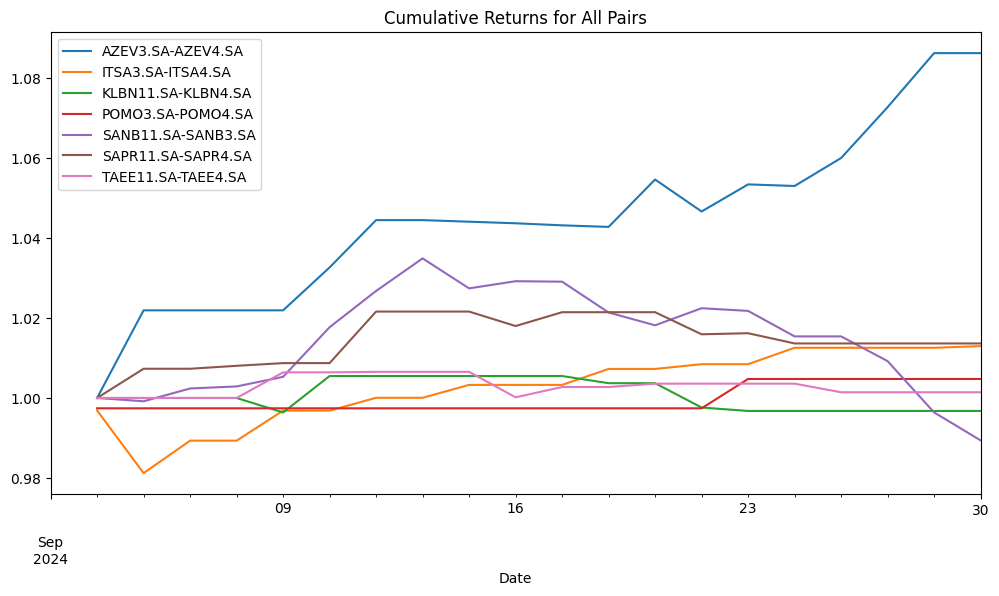

In [9]:
# Apply strategy to all pairs
def apply_strategy_to_all_pairs(min_p_value_pairs, df_test_data, models_and_means):
    df_positions = pd.DataFrame(index=df_test_data.index)
    individual_returns = {}

    plt.figure(figsize=(12, 6))  # Single figure for all pairs

    for i, (index, row) in enumerate(min_p_value_pairs.iterrows()):
        stock1 = row['Stock1']
        stock2 = row['Stock2']

        # Prepare test data
        df_test = pd.DataFrame({
            'Stock1_Open': df_test_data['Open'][stock1],
            'Stock1_Close': df_test_data['Adj Close'][stock1],
            'Stock2_Open': df_test_data['Open'][stock2],
            'Stock2_Close': df_test_data['Adj Close'][stock2]
        }).dropna()

        model = models_and_means[i]['model']
        mean_spread = models_and_means[i]['mean_spread']
        std_spread = models_and_means[i]['std_spread']

        # Calculate spread
        df_test['Spread'] = df_test['Stock1_Close'] - model.params[1] * df_test['Stock2_Close']

        # Define trading signals
        df_test['Buy_Signal'] = df_test['Spread'] < (mean_spread - std_spread)
        df_test['Sell_Signal'] = df_test['Spread'] > (mean_spread + std_spread)

        # Determine positions
        df_test['Position'] = 0
        df_test['Position'] = np.where(df_test['Buy_Signal'], 1, np.where(df_test['Sell_Signal'], -1, 0))

        # Shift position for next day
        df_test['Position'] = df_test['Position'].shift()

        # Apply costs and taxes
        df_test = apply_costs_and_taxes(df_test)

        # Store positions and returns
        df_positions[f'{stock1}-{stock2}_Position'] = df_test['Position']
        df_positions[f'{stock1}-{stock2}_Strategy_Return'] = df_test['Strategy_Return_After_Tax']

        # Calculate cumulative return
        df_test['Cumulative_Strategy_Return'] = (1 + df_test['Strategy_Return_After_Tax']).cumprod()
        individual_returns[f'{stock1}-{stock2}'] = df_test['Cumulative_Strategy_Return']

        # Plot cumulative return
        df_test['Cumulative_Strategy_Return'].plot(label=f'{stock1}-{stock2}')

    plt.title('Cumulative Returns for All Pairs')
    plt.legend()
    plt.show()

    return df_positions, individual_returns

# Execute the strategy
df_positions, individual_returns = apply_strategy_to_all_pairs(min_p_value_pairs, df_test, models_and_means)

## Aggregating Portfolio Returns

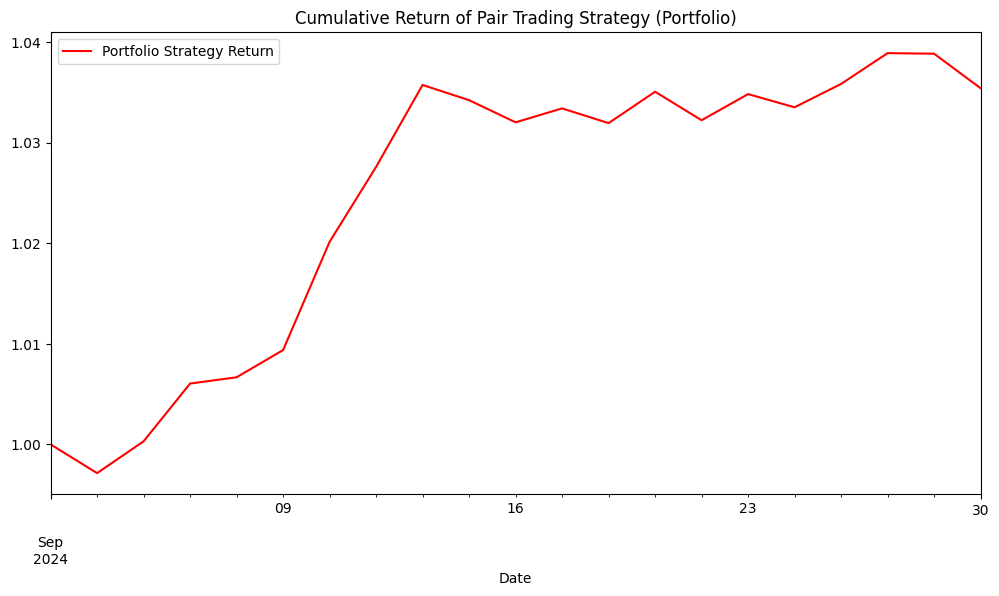

In [10]:
# Calculate active pairs
active_pairs = df_positions.filter(like='_Strategy_Return').apply(lambda row: row != 0, axis=1)

# Filter only active returns
strategy_returns = df_positions.filter(like='_Strategy_Return')
active_returns = strategy_returns.where(active_pairs, np.nan)

# Calculate mean returns
df_positions['Total_Strategy_Return'] = active_returns.mean(axis=1).fillna(0)

# Calculate cumulative return
df_positions['Cumulative_Strategy_Return'] = (1 + df_positions['Total_Strategy_Return']).cumprod()

# Plot cumulative portfolio return
plt.figure(figsize=(12, 6))
df_positions['Cumulative_Strategy_Return'].plot(label='Portfolio Strategy Return', color='red')
plt.title('Cumulative Return of Pair Trading Strategy (Portfolio)')
plt.legend()
plt.show()

In [11]:
# Final return
final_return = df_positions['Cumulative_Strategy_Return'].iloc[-1] - 1
print(f'Total return from the portfolio strategy: {final_return:.2%}')

Total return from the portfolio strategy: 3.54%
